In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from __future__ import division

import graphlab as gl
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [29]:
def generate_waveforms(channels_nr=4, waveforms_nr=2, data_len=10000, window_size=21):
    # single channel waveform prototype
    # two phases of sine for the basic features
    waveform_proto = sp.sin(sp.linspace(0, 4*sp.pi, window_size))
    waveform_proto -= sp.cos(sp.linspace(sp.pi, 3*sp.pi, window_size))
    
    # hanning window levels the edges to zero and gets the overall relative scale right
    # to generate more prototypes you can just get creative with the windows and/or
    # combine more harmonics before windowing
    waveform_proto *= sp.hanning(window_size)

    # constructing multi channel waveforms
    scale = sp.linspace(0, 2, window_size)
    waveforms_data = []
    for _ in range(waveforms_nr):
        channels_data = []
        for j in range(channels_nr):
            channels_data.append(waveform_proto * (2*j+1) * scale)
        channels_data = sp.vstack(channels_data).T
        waveforms_data.append(channels_data)

    xi = sp.concatenate(waveforms_data)
    # now we have two multi-channel waveforms with different amplitude distributions

    # spike trains [[timestamp, label]] interleaved list
    nu1_t = sp.arange(0, data_len, 500)
    nu2_t = sp.arange(300, data_len, 500)
    nu1 = sp.vstack((nu1_t, sp.ones_like(nu1_t)*0))
    nu2 = sp.vstack((nu2_t, sp.ones_like(nu1_t)*1))
    nu = sp.hstack((nu1,nu2))
    # can order this by timestamps if you prefer that
    #temporal_order = nu[0].argsort()
    #nu[0] = nu[0,temporal_order]
    #nu[1] = nu[1,temporal_order]

    # constructing the waveform transients
    s = sp.zeros((xi.shape[0], data_len, channels_nr))
    for unit in range(xi.shape[0]):
        st = nu[0, nu[1] == unit]
        for t in st:
            s[unit, t: t+window_size] += xi[unit]

    # create noise - you can be more fancy here, for starters Gaussian white noise should be ok
    eta = sp.randn(data_len, channels_nr)

    # now we have all components of the generative model.
    data = s.sum(axis=0) + eta
    
    # using first dimension for time, second for channels
    return data

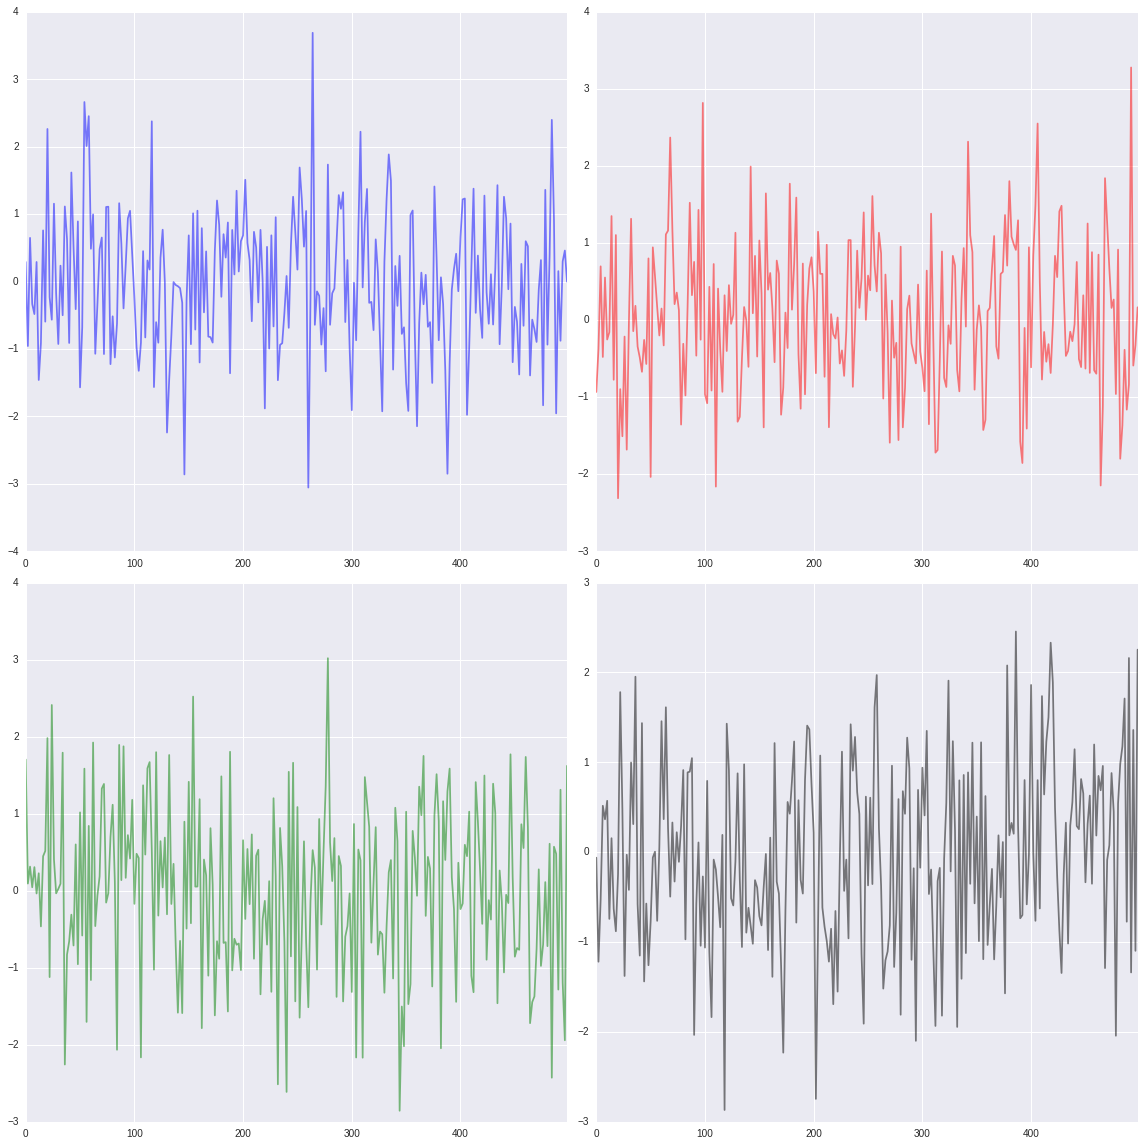

In [33]:
data = pd.DataFrame(generate_waveforms())
f, axes = plt.subplots(2, 2, figsize=(16, 16))
data.iloc[:500:2, 0].plot(alpha=0.5, ax=axes[0, 0], c='b')
data.iloc[:500:2, 1].plot(alpha=0.5, ax=axes[0, 1], c='r')
data.iloc[:500:2, 2].plot(alpha=0.5, ax=axes[1, 0], c='g')
data.iloc[:500:2, 3].plot(alpha=0.5, ax=axes[1, 1], c='k')
f.tight_layout()